## 数据来源和整体思路
### 数据选择
选取上证主板A股非ST股票作为股票池，数据来源CSMAR
### 模型思路
参考Gatev(2006)，使用最小距离选择股票对，再构建协整模型进行配对交易

根据SSD排序分别对top3、top5、top10的配对进行交易并进行比较

形成期为20181018-20191018，交易期为20191019-20200419

In [1]:
import pandas as pd
import numpy as np
import pickle
from itertools import combinations
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

In [2]:
# 读取处理后的数据
with open("data.bin", "rb") as f:
    data = pickle.load(f)
with open("SSD.bin", "rb") as f:
    assets_SSD = pickle.load(f)
# 模型结果demo
with open("models.bin", "rb") as f:
    models = pickle.load(f)

# 指定形成期日期
form_start = "2019-10-18"
form_end = "2020-10-18"
# 交易日期
trade_start = "2020-10-19"
trade_end = "2021-04-19"

def getPrice(asset, start, end, data):
    '''
    @Description
    获取名称为asset的前t价格序列
    ------------
    @Params
    asset, str, code
    start, end, str
    data, dict code:df
    ------------
    @Returns
    prices, array
    '''
    return np.array(data[asset].loc[start:end, "Clsprc"].values, dtype=float)


def getDPrice(asset, start, end, data):
    '''
    @Description
    获取一阶差分序列
    ------------
    @Params
    asset, str, code
    start, end, str
    data, dict code:df
    ------------
    @Returns
    prices, array
    '''
    temp = data[asset].loc[start:end, "Clsprc"]
    return np.array((temp-temp.shift(1)).dropna().values, dtype=float)


## 1数据预处理
(运行时间可能很久)

无需再运行这一部分代码，已经使用pickle保存中间结果

In [9]:
# 处理原始数据导出为股票代码对应df的字典
data = pd.read_excel("TRD_Dalyr.xlsx")
data = data[2:]
days = data.groupby("Stkcd").count().apply(max)[0]
temp = dict()
for code, df in data.groupby("Stkcd"):
    if len(df)!=days:
        continue
    df.loc[:, "Trddt"] = pd.to_datetime(df["Trddt"], format="%Y-%m-%d")
    temp[code] = df.set_index("Trddt")
# with open("data.bin", "wb") as f:
#     pickle.dump(temp, f)


/Users/zch/anaconda3/lib/python3.8/site-packages/openpyxl/styles/stylesheet.py:221: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [12]:
def calSSD(asset1, asset2, form_start, form_end, data):
    '''
    @Description
    计算两个序列的距离，返回square sum of deviation
    ------------
    @Params
    asset1, asset2, string
    form_start, form_end, str like '2019-10-18'
    data, dict str:df
    ------------
    @Returns
    ssd, float
    '''
    # 根据形成期计算距离
    x1 = calCumReturn(data[asset1].loc[form_start:form_end, "Clsprc"])
    x2 = calCumReturn(data[asset2].loc[form_start:form_end, "Clsprc"])
    return np.sum((x1-x2)**2)


def calCumReturn(close):
    '''
    @Description
    计算累积收益率
    ------------
    @Params
    close, Series, close price
    ------------
    @Returns
    Series
    '''
    temp = (close - close.shift(1))/close.shift(1)
    return (1+temp).cumprod()

In [11]:
# data:Dict, {code:df} 读取数据
with open("data.bin", "rb") as f:
    data = pickle.load(f)
data["600000"].head()

,Stkcd,Clsprc
Trddt,,
2019-10-18,600000,12.78
2019-10-21,600000,12.91
2019-10-22,600000,12.93
2019-10-23,600000,12.86
2019-10-24,600000,13.09


In [ ]:
assets = list(data.keys())
assets_SSD = dict()  # 记录SSD信息，用于分组
for asset1, asset2 in combinations(assets, 2):
    assets_SSD[f"{asset1}-{asset2}"] = calSSD(
        asset1, asset2, form_start, form_end, data)
# 按大小排序
assets_SSD = sorted(assets_SSD.items(), key=lambda d: d[1])

# 保存结果
# with open("SSD.bin", "wb") as f:
#     pickle.dump(assets_SSD, f)


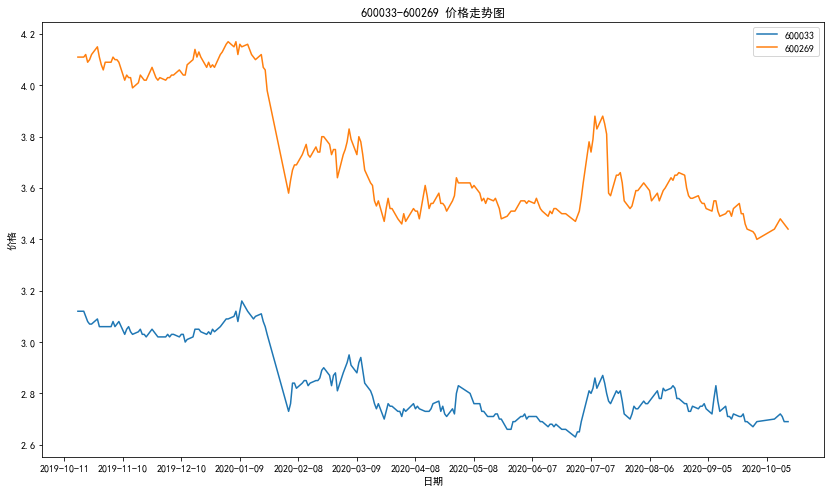

In [26]:
with open("SSD.bin", "rb") as f:
    assets_SSD = pickle.load(f)
# 挑选其中一对进行绘制
asset1, asset2 = assets_SSD[2][0].split("-")
fig, ax = plt.subplots(figsize=(14, 8))
p1 = data[asset1].loc[form_start:form_end, :]
p2 = data[asset2].loc[form_start:form_end, :]
ax.plot(p1.Clsprc, label=asset1)
ax.plot(p2.Clsprc, label=asset2)
# plt.tight_layout()
# ax.legend(prop=zhfont)
ax.legend()
ax.set_xlabel(u"日期")
ax.set_ylabel(u"价格")
ax.set_title(f"{asset1}-{asset2} 价格走势图")
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(30))
plt.show()

## 2协整模型配对
运行可能需要很长时间，已经保存结果到models.bin

In [ ]:
def cointegration(start, end, data, SSD, alpha=0.05):
    '''
    @Description
    根据协整寻找符合一阶协整的配对
    ------------
    @Params
    start, end, str, time like '2019-10-18'
    data, dict code:df
    SSD, list[tuple("asset1-asset2", ssd value)]
    alpha, float default 0.05, level of significance
    ------------
    @Returns
    models, list, [index, result], index corresponding to SSD
    '''
    models = []  # 保存序号和回归结果
    for idx, pairs in enumerate(SSD):
        asset1, asset2 = pairs[0].split("-")
        y = getPrice(asset1, start, end, data)
        x = getPrice(asset2, start, end, data)
        # 单位根检验 pvalue
        if adfuller(y)[1] < alpha or adfuller(x)[1] < alpha:
            continue
        # 一阶差分单位根检验 pvalue
        p1 = adfuller(getDPrice(asset1, start, end, data))[1]
        p2 = adfuller(getDPrice(asset2, start, end, data))[1]
        if p1 > alpha or p2 > alpha:
            continue
        # 检验协整关系
        X = sm.add_constant(x)
        result = sm.OLS(y, X).fit()
        # 残差单位根检验
        if adfuller(result.resid)[1] > alpha:
            continue
        models.append([idx, result])
    return models

In [ ]:
# 载入数据 和前面重复
with open("data.bin", "rb") as f:
    data = pickle.load(f)
with open("SSD.bin", "rb") as f:
    assets_SSD = pickle.load(f)
# 取top10000配对进行协整检验
assets_SSD = assets_SSD[:10000]
form_start = "2019-10-18"
form_end = "2020-10-18"
models = cointegration(form_start, form_end, data, assets_SSD, alpha=0.05)
# 保存模型参数
# with open("models.bin", "wb") as f:
#     pickle.dump(models, f)

## 3形成期配对展示

In [22]:
# 模型结果demo
with open("models.bin", "rb") as f:
    models = pickle.load(f)

In [29]:
idx = models[1][0] # 和上面走势图展示的股票代码对应
print(f"股票代码: {assets_SSD[idx][0]}")
models[1][1].summary()

股票代码: 600033-600269


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.959
Model:                            OLS   Adj. R-squared:                  0.959
Method:                 Least Squares   F-statistic:                     5597.
Date:                Tue, 19 Oct 2021   Prob (F-statistic):          2.52e-168
Time:                        15:40:28   Log-Likelihood:                 505.50
No. Observations:                 242   AIC:                            -1007.
Df Residuals:                     240   BIC:                            -1000.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6106      0.030     20.405      0.000       0.552       0.670
x1             0.5993      0.008     74.815      0.000       0.583       0.615
==============================================================================
Omnibus:                        5.084   Durbin-Watson:                   0.387
Prob(Omnibus):                  0.079   Jarque-Bera (JB):                4.750
Skew:                          -0.326   Prob(JB):                       0.0930
Kurtosis:                       3.217   Cond. No.                         61.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

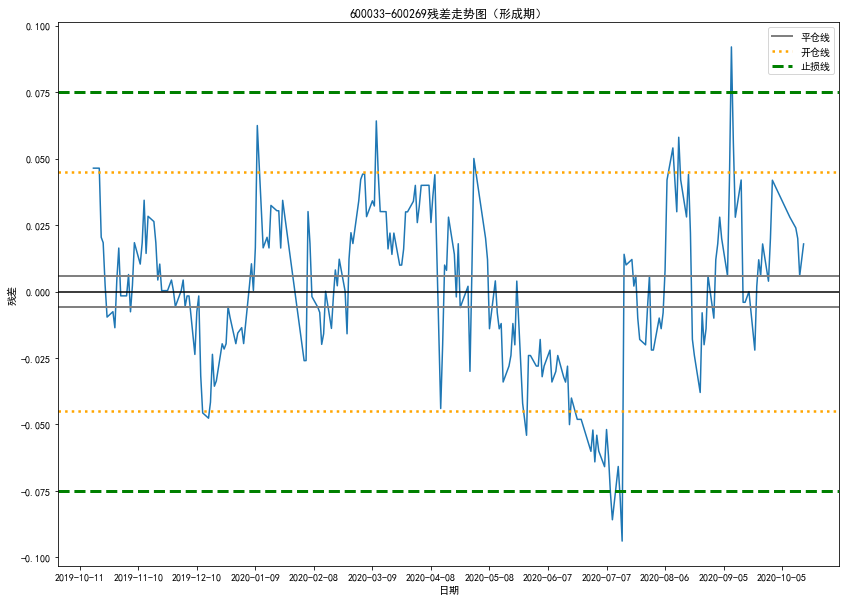

In [44]:
# 残差图
fig, ax = plt.subplots(figsize=(14, 10))
# 日期
x = data[asset1].loc[form_start:form_end, :].index
resid = models[1][1].resid
ax.plot(x, resid)
mu = np.mean(resid)
sd = np.std(resid)
ax.axhline(y=mu, color='black')
ax.axhline(y=mu+0.2*sd, color='gray', ls='-', lw=2, label="平仓线")
ax.axhline(y=mu-0.2*sd, color='gray', ls='-', lw=2)
ax.axhline(y=mu+1.5*sd, color='orange', ls=':', lw=2.5, label="开仓线")
ax.axhline(y=mu-1.5*sd, color='orange', ls=':', lw=2.5)
ax.axhline(y=mu+2.5*sd, color='green', ls='--', lw=3, label="止损线")
ax.axhline(y=mu-2.5*sd, color='green', ls='--', lw=3)
ax.set_title(f"{assets_SSD[idx][0]}残差走势图（形成期）")
ax.set_ylabel("残差")
ax.set_xlabel("日期")
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(30))
plt.legend()
# plt.savefig("价差走势图形成期.jpg", dpi=300)
plt.show()

## 4交易期

In [9]:
class Arbitrageur:
    '''
    配对交易类，包含配对交易代码和图表绘制
    基于形成期数据用于交易期策略模拟
    '''
    def __init__(self, y, x, dates, model, account=1e4, unit=100, size=2000,
                 open_thsh=1.5, close_thsh=0.2, stop_thsh=2.5, verbose=False, y_code="", x_code=""):
        '''
        @Description
        初始化
        ------------
        @Params
        y, Series, asset1
        x, Series, asset2
        dates, Series, datetime
        model, 协整模型
        account, float default 1e4, 初始资金
        unit, int default 100, 最小交易单位
        size, int default 2000, 单次交易单位
        open_thsh, float default 1.5, 开仓阈值
        close_thsh, float default 0.2, 平仓阈值
        stop_thsh, float default 2.5, 止损阈值
        cost_rate, float default 0, 交易成本占数额比例
        verbose, bool default False, 是否输出交易过程
        y_code, x_code, str, code
        '''
        self.y = y
        self.x = x
        self.dates = dates
        self.unit = unit
        self.size = size
        self.alpha = model.params[0]
        self.beta = model.params[1]
        mu = np.mean(model.resid)
        sd = np.std(model.resid, ddof=1)
        # 设置交易区间
        self.setInterval(mu, sd, open_thsh, close_thsh, stop_thsh)
        # 开平仓信号
        self.signals = np.zeros(self.n, dtype=int)
        self.getSignals()
        # 仓位记录
        self.positions = np.zeros(self.n, dtype=int)
        self.getPositions()
        
        self.account = [account for i in range(self.n)]
        self.verbose = verbose
        self.y_code = y_code
        self.x_code = x_code

    def setInterval(self, mu, sd, open_thsh, close_thsh, stop_thsh):
        '''
        @Description
        设置交易区间
        ------------
        @Params
        mu, float, mean
        sd, float, std
        open_thsh, float default 1.5, 开仓阈值
        close_thsh, float default 0.2, 平仓阈值
        stop_thsh, float default 2.5, 止损阈值
        '''
        # 交易期价差
        spread = self.y-self.beta*self.x-self.alpha
        # 交易信号区间
        self.level = (float('-inf'), mu-stop_thsh*sd, mu-open_thsh*sd,
                      mu-close_thsh*sd, mu+close_thsh*sd,
                      mu+open_thsh*sd, mu+stop_thsh*sd, float('inf'))
        # 交易期价差所处范围空间
        self.itv = pd.cut(spread, self.level, labels=False)-3
        self.n = len(self.itv)
    
    def getSignals(self):
        '''
        @Description
        获取交易信号
        '''
        for i in range(1, self.n):
            if self.itv[i-1] == 1 and self.itv[i] == 2:  # 从1区到2区，向上突破开仓线，如之前未开仓则开仓
                self.signals[i] = -2
            elif self.itv[i-1] == 1 and self.itv[i] == 0:  # 从1区到0区，向下突破平仓线，如之前开仓则平仓
                self.signals[i] = 2
            elif self.itv[i-1] == 2 and self.itv[i] == 3:  # 从2区到3区，向上突破止损线，如之前开仓则平仓止损
                self.signals[i] = 3
            elif self.itv[i-1] == -1 and self.itv[i] == -2:  # 从-1区到-2区，向下突破开仓线，如之前未开仓则开仓
                self.signals[i] = 1
            elif self.itv[i-1] == -1 and self.itv[i] == 0:  # 从-1区到0区，向上突破平仓线，如之前开仓则平仓
                self.signals[i] = -1
            elif self.itv[i-1] == -2 and self.itv[i] == -3:  # 从-2区到-3区，向下突破止损线，如之前开仓则平仓止损
                self.signals[i] = -3

    def getPositions(self):
        '''
        @Description
        根据信号获取仓位
        '''
        self.positions[0] = self.signals[0]
        for i in range(1, self.n):
            self.positions[i] = self.positions[i-1]
            if self.signals[i]==1: # -1区到-2区，向下突破开仓线，买入y卖出x
                self.positions[i]=1
            elif self.signals[i]==-2:  # 1区到2区，向上突破开仓线
                self.positions[i]=-1
            elif self.signals[i]==-1: # -1区到0区，向上突破平仓线
                self.positions[i]=0
            elif self.signals[i]==2: # 1区到0区，向下突破平仓线
                self.positions[i]=0
            elif self.signals[i]==3: # 2区到3区，向上突破止损线
                self.positions[i]=0
            elif self.signals[i]==-3: # -2区到-3区，向下突破止损线
                self.positions[i]=0            

    def getShareX(self, i):
        '''
        @Description
        计算得到x的股票数
        ------------
        @Params
        i, int, iteration number
        '''
        # 最小单位为self.unit
        self.share_x[i] = (int((-self.beta*self.share_y[i]*self.y[i])/self.x[i])//self.unit)*self.unit

    def close(self, i):
        '''
        @Description
        平仓
        ------------
        @Params
        i, int, iteration number
        '''
        self.tempx = self.share_x[i-1]*self.x[i]
        self.tempy = self.share_y[i-1]*self.y[i]
        self.account[i] = self.account[i-1] + (self.tempx+self.tempy)
    
    def build(self, i):
        '''
        @Description
        开仓
        ------------
        @Params
        i, int, iteration number
        '''
        self.tempx = self.share_x[i]*self.x[i]
        self.tempy = self.share_y[i]*self.y[i]
        self.account[i] = self.account[i-1] - (self.tempx+self.tempy)

    def printLog(self, i, action):
        '''
        @Description
        输出交易信息
        ------------
        @Params
        i, int, iteration number
        action, int, 指定类别
        '''
        if not self.verbose:
            return
        if action == 0:
            print(f"{self.dates[i]} 开仓：买入{self.tempy:.2f}元{self.y_code}股票，同时卖空{-self.tempx:.2f}元{self.x_code}股票")
        elif action == 1:
            print(f"{self.dates[i]} 开仓：卖空{-self.tempy:.2f}元{self.y_code}股票，同时买入{self.tempx:.2f}元{self.x_code}股票")
        elif action == 2:
            print(f"{self.dates[i]} 平仓：卖出{self.tempy:.2f}元{self.y_code}股票，同时买入{-self.tempx:.2f}元{self.x_code}股票")
        elif action == 3:
            print(f"{self.dates[i]} 平仓：买入{-self.tempy:.2f}元{self.y_code}股票，同时卖出{-self.tempx:.2f}元{self.x_code}股票")
    
    def getProfit(self):
        '''
        @Description
        返回收益
        ------------
        @Returns
        profit, float
        '''
        return self.account[-1]-self.account[0]

    def getTradeInfo(self):
        '''
        @Description
        获取交易全过程的仓位账户等信息
        ------------
        @Returns
        Df(index="date", "account", "share x", "share y")
        '''
        stocks = self.share_y*self.y+self.share_x*self.x
        assets = stocks+self.account
        return pd.DataFrame(index=self.dates, 
                    data={"Assets":assets, "Account":self.account, f"{self.y_code} shares": self.share_y, 
                    f"{self.x_code} shares": self.share_x, "Stock Value":stocks})

    def trade(self):
        '''
        @Description
        根据仓位交易
        '''
        self.share_y = self.size*self.positions
        self.share_x = np.zeros(self.n, dtype=float)
        # 记录每一次的仓位
        self.tempx = 0
        self.tempy = 0
        self.getShareX(0)
        for i in range(1, self.n):
            if self.positions[i-1] == 0 and self.positions[i] == 1:  
                # 开仓+y-x
                self.getShareX(i) 
                self.build(i)
                self.printLog(i,0)
            elif self.positions[i-1] == 0 and self.positions[i] == -1:
                # 开仓-y+x
                self.getShareX(i)
                self.build(i)
                self.printLog(i,1)
            elif self.positions[i-1] == 1 and self.positions[i] == 0:
                # 平仓-y+x
                self.share_x[i] = 0
                self.close(i)
                self.printLog(i,2)  
            elif self.positions[i-1] == -1 and self.positions[i] == 0:
                # 平仓+y-x
                self.share_x[i] = 0
                self.close(i)
                self.printLog(i,3) 
            elif self.positions[i-1] == -1 and self.positions[i] == 1:
                # 平仓 +y-x
                self.close(i)
                self.printLog(i,3)
                # 开仓 +y-x
                self.getShareX(i)
                self.build(i)
                self.printLog(i,0)
            elif self.positions[i-1] == 1 and self.positions[i] == -1:
                # 平仓-y+x
                self.close(i)
                self.printLog(i,2)
                # 开仓-y+x
                self.getShareX(i)
                self.build(i)
                self.printLog(i,1)
            else:
                self.account[i] = self.account[i-1]
                self.share_x[i] = self.share_x[i-1]


In [29]:
# 单配对展示
idx = models[1][0]  # 和上面走势图展示的股票代码对应
asset1, asset2 = assets_SSD[idx][0].split("-")
print(f"两只股票代码为y:{asset1}  x:{asset2}")
dates = data[asset1].loc[trade_start:trade_end, :].index.date
y = getPrice(asset1, trade_start, trade_end, data)
x = getPrice(asset2, trade_start, trade_end, data)
robot = Arbitrageur(y, x, dates, models[1][1], account=10000,
                verbose=True, y_code=asset1, x_code=asset2)

两只股票代码为y:600033  x:600269


In [30]:
robot.trade()

2021-01-11 开仓：卖空5280.00元600033股票，同时买入2979.00元600269股票
2021-01-22 平仓：买入5200.00元600033股票，同时卖出-2979.00元600269股票
2021-01-29 开仓：买入5020.00元600033股票，同时卖空3270.00元600269股票
2021-02-01 平仓：卖出5020.00元600033股票，同时买入3300.00元600269股票
2021-02-22 开仓：买入5240.00元600033股票，同时卖空3430.00元600269股票
2021-04-02 平仓：卖出5380.00元600033股票，同时买入3600.00元600269股票


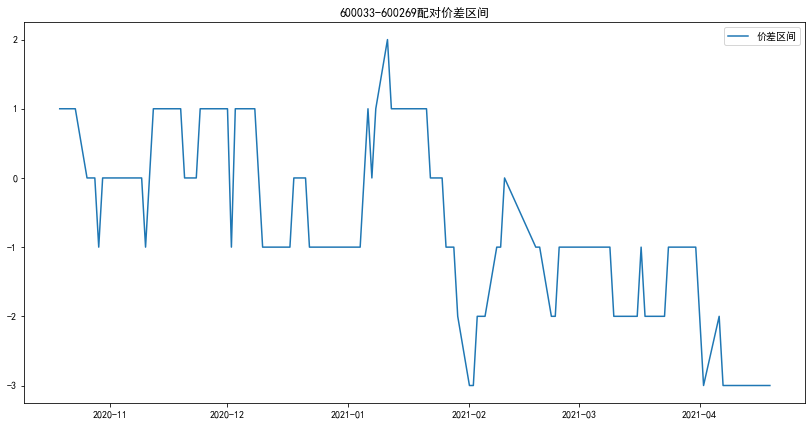

In [13]:
# 价差区间绘制
fig, ax = plt.subplots(figsize=(14, 7))
ax.plot(dates, robot.itv, label="价差区间")
ax.set_title(f"{asset1}-{asset2}配对价差区间")
ax.legend()
plt.show()

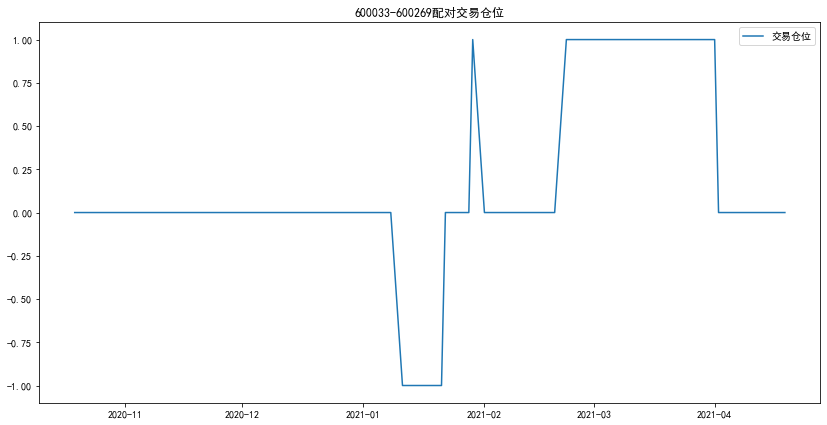

In [14]:
fig, ax = plt.subplots(figsize=(14, 7))
ax.plot(dates, robot.positions, label="交易仓位")
ax.set_title(f"{asset1}-{asset2}配对交易仓位")
ax.legend()
plt.show()

In [31]:
trade_info = robot.getTradeInfo()

In [32]:
print(trade_info)

             Assets  Account  600033 shares  600269 shares  Stock Value
2020-10-19  10000.0  10000.0              0            0.0          0.0
2020-10-20  10000.0  10000.0              0            0.0          0.0
2020-10-21  10000.0  10000.0              0            0.0          0.0
2020-10-22  10000.0  10000.0              0            0.0          0.0
2020-10-23  10000.0  10000.0              0            0.0          0.0
...             ...      ...            ...            ...          ...
2021-04-13  10020.0  10020.0              0            0.0          0.0
2021-04-14  10020.0  10020.0              0            0.0          0.0
2021-04-15  10020.0  10020.0              0            0.0          0.0
2021-04-16  10020.0  10020.0              0            0.0          0.0
2021-04-19  10020.0  10020.0              0            0.0          0.0

[124 rows x 5 columns]


<AxesSubplot:title={'center':'配对交易账户'}>

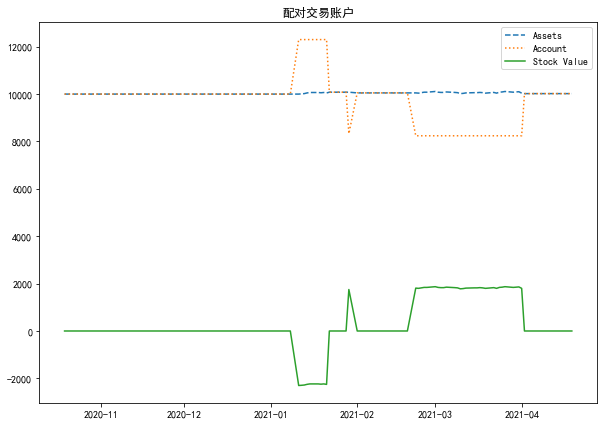

In [35]:
trade_info.iloc[:, [0,1,4]].plot(figsize=(10,7), style=["--", ":"], title="配对交易账户")

## 5多组配对收益情况

In [3]:
# 输出重定向到日志文件
import sys

In [30]:
f = open("tradeLog.txt", "a", encoding="utf-8")
sys.stdout = f
# 取top100，输出日志保存在tradeLog.txt
account = 2e4
profits = []
for i in range(100):
    idx = models[i][0]
    asset1, asset2 = assets_SSD[idx][0].split("-")
    dates = data[asset1].loc[trade_start:trade_end, :].index.date
    y = getPrice(asset1, trade_start, trade_end, data)
    x = getPrice(asset2, trade_start, trade_end, data)
    robot = Arbitrageur(y, x, dates, models[i][1], account=2e4,
                        verbose=True, y_code=asset1, x_code=asset2)
    print(f"配对{i} y:{asset1}  x:{asset2}")
    robot.trade()
    profit = robot.getProfit()

    profits.append(profit)
    print(f"总收益为{profit:.2f}元")
    print("-"*40)
sys.stdout = sys.__stdout__
f.close()


In [33]:
loss_count = sum([1 for profit in profits if profit < 0])
gain_count = sum([1 for profit in profits if profit > 0])
f"在top100配对中，盈利的配对有{gain_count}对，损失的配对有{loss_count}对"

'在top100配对中，盈利的配对有29对，损失的配对有62对'

In [34]:
loss = sum([profit for profit in profits if profit < 0])
gain = sum([profit for profit in profits if profit > 0])
f"盈利配对共盈利{gain:.2f}元，损失配对共损失{loss:.2f}"

'盈利配对共盈利204952.00元，损失配对共损失-68676.00'